### 1. Import required libraries

In [1]:
from keras.models import Sequential, Model
from keras.layers import Lambda,Average, Maximum, Conv2DTranspose,Dropout,Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Input, concatenate, Activation
from keras.metrics import MeanIoU
from keras import callbacks
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
from keras.utils.np_utils import to_categorical   
import os # accessing directory structure
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import cv2
import numpy as np # linear algebra
# from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
# from sklearn.metrics import roc_auc_score,confusion_matrix, classification_report

### Import Dataset

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
DATASET_PATH = "/content/gdrive/My Drive/image_dataset"
print(os.listdir(DATASET_PATH))

['image_2', 'gt_image_2']


In [4]:
img_path =DATASET_PATH + "/image_2/"
label_path = DATASET_PATH + "/gt_image_2/"

In [5]:
def load_dataset():
    label_file = []
    img_file = []
    for filename in os.listdir(img_path):
    #     print(filename)
        im_name_splits = filename.split(os.sep)[-1].split('.')[0].split('_')
        lbl_path = os.path.join(im_name_splits[0] + '_road_' + im_name_splits[1] + '.png')
        label_file.append(lbl_path)
        img_file.append(filename)
    #     print(lbl_path)
    print("Number of images and ground truth in dataset: ", len(label_file),len(img_file))
    # lbl_tmp = cv2.imread(lbl_path, cv2.IMREAD_UNCHANGED)
    return img_file, label_file


In [6]:
img_file, label_file = load_dataset()

Number of images and ground truth in dataset:  289 289


### Split and transform image data to vector data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(img_file, label_file, test_size=0.33, random_state=42)
print(len(X_train),len(X_test))

193 96


In [8]:
def imageToVector(img,clus_img,label_img):
    
    mean_rgb = [103.939, 116.779, 123.68]
    mean = np.array(mean_rgb)
    img_size = (640, 128)
    
    imgp = np.array(img, dtype=np.uint8)
    img = imgp.astype(np.single)
    img -= mean
    img = cv2.resize(img, img_size)
    img = img.transpose(2, 0, 1)
    
    seg_img = np.array(clus_img, dtype=np.uint8)
    seg_img = seg_img.astype(np.single) / 128
    seg_img = seg_img - np.mean(seg_img[seg_img>0]) 
    seg_img = cv2.resize(seg_img, img_size)
    seg_img = seg_img.transpose(2, 0, 1)
    
    lbl_tmp = np.array(label_img, dtype=np.uint8)
    lbl =  np.zeros( (imgp.shape[0], imgp.shape[1]), np.uint8)
    lbl[lbl_tmp[:,:,0] > 0] = 1
    lbl[(lbl_tmp[:,:,2] > 0) & (lbl_tmp[:,:,0] == 0)] = 0
    lbl = cv2.resize(lbl, (int(img_size[1]), int(img_size[0])), interpolation=cv2.INTER_NEAREST)
    
    return img, seg_img, lbl

### Generate basic segmented image using K-means


---


###### For improvement of accuracy we initially segment the image using k-means clustering and use the same for feature extraction and fusion.

In [9]:
def getClusteredImage(img):
    clus_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
#     plt.imshow(clus_img)
#     plt.show()
    pixel_values = clus_img.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # number of clusters (K)
    k = 3
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()
    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(clus_img.shape)
    # show the image
#     plt.imshow(segmented_image)
#     plt.show()

    return segmented_image

### Load and transform images and ground truths

In [10]:
def loadData(file_list,label_list):
    for i in range(len(file_list)):
    #     print()
        img = cv2.imread(img_path+file_list[i])
        clus_img = getClusteredImage(img)
        label = cv2.imread(label_path+label_list[i], cv2.IMREAD_UNCHANGED)
        
        img,seg_img,lbl = imageToVector(img,clus_img,label)
        if i == 0:
            vec_img = img[np.newaxis, :, :,:]
            vec_clus = seg_img[np.newaxis, :, :,:]
            vec_label = lbl[np.newaxis,:,:]
        else:
            imgp = img[np.newaxis, :, :,:]
            vec_img = np.append(vec_img, imgp, axis=0)

            clus_imgp = seg_img[np.newaxis, :, :,:]
            vec_clus = np.append(vec_clus, clus_imgp, axis=0)

            labp = lbl[np.newaxis,:,:]
            vec_label = np.append(vec_label, labp, axis=0)


    print("Image array shape: ",vec_img.shape)
    print("Clustered image array shape: ",vec_clus.shape)
    print("Ground truth array shape: ",vec_label.shape)
    return vec_img, vec_clus, vec_label
# print(train_label2.shape)

In [11]:
print("Preparing training data")
train_img, train_clus, train_label = loadData(X_train,y_train)
print("Preparing test data")
test_img, test_clus, test_label = loadData(X_test,y_test)

Preparing training data
Image array shape:  (193, 3, 128, 640)
Clustered image array shape:  (193, 3, 128, 640)
Ground truth array shape:  (193, 640, 128)
Preparing test data
Image array shape:  (96, 3, 128, 640)
Clustered image array shape:  (96, 3, 128, 640)
Ground truth array shape:  (96, 640, 128)


### Convert ground truth data to categorical for two classes : Road and Non-Road categories 

In [12]:
train_label2 = to_categorical(train_label, num_classes=2)
test_label2 = to_categorical(test_label, num_classes=2)
print("Train label shape: ",train_label2.shape)
print("Test label shape: ", test_label2.shape)

Train label shape:  (193, 640, 128, 2)
Test label shape:  (96, 640, 128, 2)


In [13]:
#Reshape the images and labels with channels last image ordering
train_img = train_img.transpose([0,3,2,1])
train_clus = train_clus.transpose([0,3,2,1])

test_img = test_img.transpose([0,3,2,1])
test_clus = test_clus.transpose([0,3,2,1])
print("Train input and clustered image shape: ",train_img.shape, train_clus.shape)
print("Test input and clustered image shape", test_clus.shape, test_img.shape)

Train input and clustered image shape:  (193, 640, 128, 3) (193, 640, 128, 3)
Test input and clustered image shape (96, 640, 128, 3) (96, 640, 128, 3)


### Model training & Evaluation

---

*   CNN model with layers of VGG-16 model is used here for feature extraction. Features are extracted from original input image and basic segmented image obtained using K-means clustering. Features are extracted after each of 2nd, 3rd, 4th and 5th block and are fused using given fusion technique. Fused feature output are fed to next block for original input image feature extraction. Intention is to obtain precise segmentation for original input image, hence fused features are not passed to blocks to basic segmented image. 

*   For evaluation : Accuracy, Precision, Recall, AUC and Mean IOU metrics are used.



In [14]:
def create_model(fuse_type):
    img_size = (640, 128)
    img_input = Input(shape=(img_size[0],img_size[1],3), name='img_input')
    clus_img_input = Input(shape=(img_size[0],img_size[1],3), name='clus_img_input')
    IMAGE_ORDERING = "channels_last"
    #Block 1 img
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    fi1 = x
    #Block 1 clus_image
    l = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv1l', data_format=IMAGE_ORDERING)(clus_img_input)
    l = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv2l', data_format=IMAGE_ORDERING)(l)
    l = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pooll',
                     data_format=IMAGE_ORDERING)(l)
    fl1 = l
    
    
    # Block 2 img
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    fi2 = x
    
    # Block 2 clus_image 
    l = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv1l', data_format=IMAGE_ORDERING)(l)
    l = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv2l', data_format=IMAGE_ORDERING)(l)
    l = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pooll',
                     data_format=IMAGE_ORDERING)(l)
    fl2 = l
    
    # Fuse the 2nd layer output features based on given fusion type
    if fuse_type == 'weightedSum':
        fuse = Lambda(lambda x : x[0]+ 0.3*x[1])([fi2,fl2])
    elif fuse_type == 'maximum':
        fuse = Maximum()([fi2, fl2])
    elif fuse_type == 'Average':
        fuse = Average()([fi2, fl2])
    elif fuse_type == 'concatenate':
        fuse = concatenate([fi2, fl2])
    else :
        fuse = x
    x = fuse

    # Block 3 img
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    fi3 = x
    
    # Block 3 clus_image
    l = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv1l', data_format=IMAGE_ORDERING)(l)
    l = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv2l', data_format=IMAGE_ORDERING)(l)
    l = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv3l', data_format=IMAGE_ORDERING)(l)
    l = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pooll',
                     data_format=IMAGE_ORDERING)(l)
    fl3 = x
    
    # Fuse the 3rd layer output features based on given fusion type
    if fuse_type == 'weightedSum':
        fuse = Lambda(lambda x : x[0]+ 0.3*x[1])([fi3,fl3])
    elif fuse_type == 'maximum':
        fuse = Maximum()([fi3, fl3])
    elif fuse_type == 'Average':
        fuse = Average()([fi3, fl3])
    elif fuse_type == 'concatenate':
        fuse = concatenate([fi3, fl3])
    else :
        fuse = x
    x = fuse
    
    # Block 4 img
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    fi4 = x
    
    # Block 4 clus_image
    l = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block4_conv1l', data_format=IMAGE_ORDERING)(l)
    l = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block4_conv2l', data_format=IMAGE_ORDERING)(l)
    l = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block4_conv3l', data_format=IMAGE_ORDERING)(l)
    l = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pooll',
                     data_format=IMAGE_ORDERING)(l)
    fl4 = x
    
    # Fuse the 4th layer output features based on given fusion type
    if fuse_type == 'weightedSum':
        fuse = Lambda(lambda x : x[0]+ 0.3*x[1])([fi4,fl4])
    elif fuse_type == 'maximum':
        fuse = Maximum()([fi4, fl4])
    elif fuse_type == 'Average':
        fuse = Average()([fi4, fl4])
    elif fuse_type == 'concatenate':
        fuse = concatenate([fi4, fl4])
    else :
        fuse = x
    x = fuse

    # Block 5 img
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)
    fi5 = x
    
    # Block 5 clus_image
    l = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv1l', data_format=IMAGE_ORDERING)(l)
    l = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv2l', data_format=IMAGE_ORDERING)(l)
    l = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv3l', data_format=IMAGE_ORDERING)(l)
    l = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pooll',
                     data_format=IMAGE_ORDERING)(l)
    fl5 = x
    
    # Fuse the 5th layer output features based on given fusion type
    if fuse_type == 'weightedSum':
        fuse = Lambda(lambda x : x[0]+ 0.3*x[1])([fi5,fl5])
    elif fuse_type == 'maximum':
        fuse = Maximum()([fi5, fl5])
    elif fuse_type == 'Average':
        fuse = Average()([fi5, fl5])
    elif fuse_type == 'concatenate':
        fuse = concatenate([fi5, fl5])
    else :
        fuse = x
    x = fuse

    # Fully connected layers
    o = (Conv2D(1024, (7, 7), activation='relu',
                padding='same', data_format=IMAGE_ORDERING))(x)
    o = Dropout(0.5)(o)
    o = (Conv2D(1024, (1, 1), activation='relu',
                padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)

    o = (Conv2D(1,  (1, 1), kernel_initializer='he_normal',
                data_format=IMAGE_ORDERING))(o)
    o = Conv2DTranspose(2, kernel_size=(32, 32),  strides=(
        32, 32), use_bias=False,  data_format=IMAGE_ORDERING)(o)
    
    # predictions
    predictions = (Activation('softmax'))(o)
    
    model = Model(inputs=[img_input, clus_img_input], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy','Precision','Recall'
    ,'AUC',MeanIoU(num_classes=2)])
    return model

In [26]:
# create model with choice of fusion type
# weightedSum : uses weighted sum of features with 0.3 weight to clustered image feature and 1 to original image
# maximum : Computes the maximum (element-wise) a list of inputs.
# Average : averages a list of inputs element-wise.
# concatenate : concatenates a list of inputs.
# no_fusion : train model only using original input without any fusion

model = create_model(fuse_type="weightedSum")
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 640, 128, 3) 0                                            
__________________________________________________________________________________________________
clus_img_input (InputLayer)     [(None, 640, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 640, 128, 64) 1792        img_input[0][0]                  
__________________________________________________________________________________________________
block1_conv1l (Conv2D)          (None, 640, 128, 64) 1792        clus_img_input[0][0]             
_______________________________________________________________________________________

In [27]:
# Fit the model to data with early stopping
# callback = callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit([train_img,train_clus], train_label2,
                    batch_size= 5,
                    epochs= 5, 
                    validation_data = ([test_img,test_clus], test_label2))
                   

Epoch 1/5
39/39 [==============================] - 1069s 27s/step - loss: 1.3618 - accuracy: 0.6172 - precision: 0.6172 - recall: 0.6172 - auc: 0.6368 - mean_io_u_2: 0.2790 - val_loss: 0.6882 - val_accuracy: 0.7362 - val_precision: 0.7362 - val_recall: 0.7362 - val_auc: 0.7335 - val_mean_io_u_2: 0.2500
Epoch 2/5
39/39 [==============================] - 1060s 27s/step - loss: 0.6244 - accuracy: 0.7515 - precision: 0.7515 - recall: 0.7515 - auc: 0.8019 - mean_io_u_2: 0.2617 - val_loss: 0.4409 - val_accuracy: 0.8771 - val_precision: 0.8771 - val_recall: 0.8771 - val_auc: 0.9306 - val_mean_io_u_2: 0.2500
Epoch 3/5
39/39 [==============================] - 1067s 27s/step - loss: 0.4186 - accuracy: 0.8489 - precision: 0.8489 - recall: 0.8489 - auc: 0.9156 - mean_io_u_2: 0.2669 - val_loss: 0.3643 - val_accuracy: 0.8790 - val_precision: 0.8790 - val_recall: 0.8790 - val_auc: 0.9467 - val_mean_io_u_2: 0.2500
Epoch 4/5
39/39 [==============================] - 1075s 28s/step - loss: 0.4046 - accur

In [28]:
#save model
model.save('model_no_fusion.h5',include_optimizer=True)

### Visualization of results

---
*   Training and validation accuracy scores are plotted to visualize the accuracy plot.
*   Output images are visualized against the original image using transparency.



In [29]:
#accuracy plot
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    # plt.savefig("acc_acc_img_5_5_weightsum.png")
    plt.show()

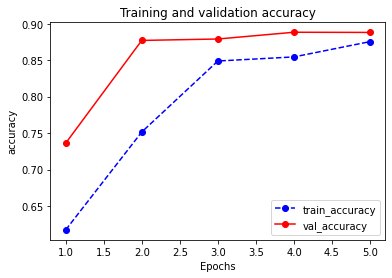

In [30]:
plot_metric(history, 'accuracy')

In [31]:
#predict output for few images for visualization
pred = model.predict([test_img[0:10],test_clus[0:10]])
pred.shape[0]

10

In [33]:
# output image are pixels are assigned green and red RGB values 
# based on the probabilities of 2 classes (Road & Non Road) predicted by model.
# output image and input image are fused using average of each pixels of each image for transparency.
rows = pred.shape[0]
images = {}
img_size = (640,128)
for j in range(rows):
    class_labels = pred[j]
    p = np.zeros((test_label.shape[1],test_label.shape[2],3), dtype=np.uint8)
    p[class_labels[:,:,0] > class_labels[:,:,1]] = [255,0,0]
    p[class_labels[:,:,0] <= class_labels[:,:,1]] = [0,255,0]
    p = cv2.resize(p,img_size)
    img = cv2.imread(img_path+X_test[j])
    imgg = np.array(img, dtype=np.uint8)
    imggp = cv2.resize(imgg,img_size)
    fused_img = (imggp/2 + p/2).astype('uint8')
#     plt.savefig("i"+str(i),fused_img)
    images['Image'+str(j)] =fused_img

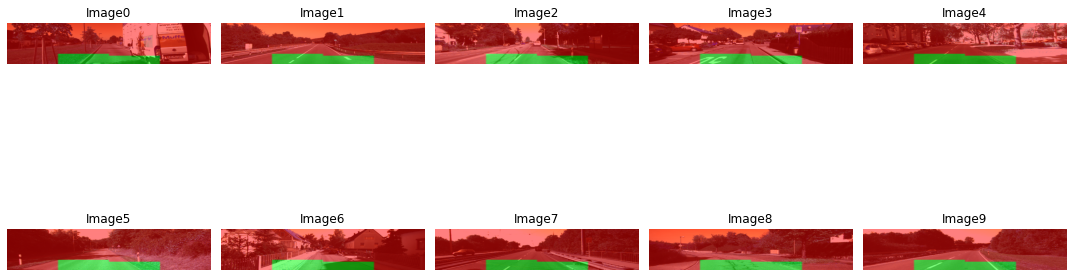

In [34]:
#visualization of output images against input images
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(15, 8) )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

# total_images = 4
# images = {'Image'+str(i): np.random.rand(100, 100) for i in range(total_images)}

display_multiple_img(images, 2,5)

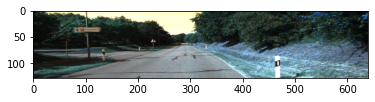

In [35]:
k = 16
x = images['Image'+str(k-10)]
plt.imshow(x)
plt.savefig("i"+str(k)+".png")

y = cv2.imread(img_path+X_test[k])
y = np.array(y, dtype=np.uint8)
y = cv2.resize(y,img_size)
plt.imshow(y)
plt.savefig("img"+str(k)+".png")